## Importing Required Library
We begin by importing a few standard Python libraries that will be used to: 
* access ZIP files
* handle in-memory file objects
* load tabular data for analysis

In [12]:
import zipfile
import io
import pandas as pd

TERRA_ZIP = "../data/raw/terra/ERC20-stablecoins.zip"

## Inventory the Data Files

In [13]:
with zipfile.ZipFile(TERRA_ZIP, "r") as z:
    terra_files = z.namelist()

terra_files

['token_transfers.csv',
 'token_transfers_V2.0.0.csv',
 'token_transfers_V3.0.0.csv',
 'price_data.zip',
 'event_data.csv']

## Load sample of token transfer

In [14]:
TRANSFERS_FILE = "token_transfers_V3.0.0.csv"  # change if needed

with zipfile.ZipFile(TERRA_ZIP) as z:
    with z.open(TRANSFERS_FILE) as f:
        df = pd.read_csv(f, nrows=200_000)

print("Sample rows:", len(df))
df.head(3)

Sample rows: 200000


,block_number,transaction_index,from_address,to_address,time_stamp,contract_address,value
0,14500001,44,0x27cbb0e6885ccb1db2dab7c2314131c94795fbef,0x8426a27add8dca73548f012d92c7f8f4bbd42a3e,1648811421,0xdac17f958d2ee523a2206206994597c13d831ec7,800.0
1,14500001,62,0x7938b1b2f2d2ec6cde2db46fcb11d824f32eae54,0xffabc91efaf240a48fe2b31d3599925d3504c3df,1648811421,0xdac17f958d2ee523a2206206994597c13d831ec7,579.0
2,14500001,64,0x4593e0fb8dcc65cd24c7f99ee64da2627e90f998,0x97138e4cb36db0185236c3d74cb39fb51cb3228b,1648811421,0xdac17f958d2ee523a2206206994597c13d831ec7,15898.0


## Examine Data Schema

In [40]:
# df.columns.tolist(), df.dtypes

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   block_number       200000 non-null  int64              
 1   transaction_index  200000 non-null  int64              
 2   from_address       200000 non-null  object             
 3   to_address         200000 non-null  object             
 4   time_stamp         200000 non-null  int64              
 5   contract_address   200000 non-null  object             
 6   value              200000 non-null  float64            
 7   timestamp          200000 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(3)
memory usage: 12.2+ MB


,block_number,transaction_index,from_address,to_address,time_stamp,contract_address,value,timestamp
0,14500001,44,0x27cbb0e6885ccb1db2dab7c2314131c94795fbef,0x8426a27add8dca73548f012d92c7f8f4bbd42a3e,1648811421,0xdac17f958d2ee523a2206206994597c13d831ec7,800.000000,2022-04-01 11:10:21+00:00
1,14500001,62,0x7938b1b2f2d2ec6cde2db46fcb11d824f32eae54,0xffabc91efaf240a48fe2b31d3599925d3504c3df,1648811421,0xdac17f958d2ee523a2206206994597c13d831ec7,579.000000,2022-04-01 11:10:21+00:00
2,14500001,64,0x4593e0fb8dcc65cd24c7f99ee64da2627e90f998,0x97138e4cb36db0185236c3d74cb39fb51cb3228b,1648811421,0xdac17f958d2ee523a2206206994597c13d831ec7,15898.000000,2022-04-01 11:10:21+00:00
3,14500001,68,0x3cd751e6b0078be393132286c442345e5dc49699,0xf4fc2e12974cc3b4d8192722430c571968025d4f,1648811421,0xdac17f958d2ee523a2206206994597c13d831ec7,200.929675,2022-04-01 11:10:21+00:00
4,14500003,0,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,0x5b0e981798f5880c25b54c5de4005f5ec1f3f46a,1648811424,0xdac17f958d2ee523a2206206994597c13d831ec7,651.675449,2022-04-01 11:10:24+00:00


## Converting Timestamps

In [37]:
df["timestamp"] = pd.to_datetime(df["time_stamp"], unit="s", errors="coerce", utc=True)

df[["time_stamp", "timestamp"]].head(3), (df["timestamp"].min(), df["timestamp"].max())


(   time_stamp                 timestamp
 0  1648811421 2022-04-01 11:10:21+00:00
 1  1648811421 2022-04-01 11:10:21+00:00
 2  1648811421 2022-04-01 11:10:21+00:00,
 (Timestamp('2022-04-01 11:10:21+0000', tz='UTC'),
  Timestamp('2022-04-02 16:22:54+0000', tz='UTC')))

## Clean ```value``` column

In [38]:
df["value"] = pd.to_numeric(df["value"], errors="coerce")
df["value"].describe()


count    2.000000e+05
mean     7.941834e+04
std      1.291046e+06
min      0.000000e+00
25%      4.718813e+02
50%      2.190007e+03
75%      1.200000e+04
max      2.000000e+08
Name: value, dtype: float64

In [41]:
contract_to_token = {
    "0x6b175474e89094c44da98b954eedeac495271d0f": "DAI",
    "0x8e870d67f660d95d5be530380d0ec0bd388289e1": "PAX",
    "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48": "USDC",
    "0xdac17f958d2ee523a2206206994597c13d831ec7": "USDT",
    "0xa47c8bf37f92abed4a126bda807a7b7498661acd": "USTC",
    "0xd2877702675e6ceb975b4a1dff9fb7baf4c91ea9": "WLUNA",
}

df["token"] = df["contract_address"].map(contract_to_token)

In [42]:
top_contracts = df["token"].value_counts().head(15)
top_contracts


token
USDT     107896
USDC      75741
DAI       12318
USTC       3113
WLUNA       627
PAX         305
Name: count, dtype: int64

In [ ]:
df_small = df.dropna(subset=["timestamp", "token", "value"]).copy()

hourly_by_contract = (
    df_small.set_index("timestamp")
            .groupby("token")
            .resample("1h")
            .agg(gross_transfer_volume=("value", "sum"),
                 num_transfers=("value", "size"))
            .reset_index()
)

hourly_by_contract.head()


C:\Users\User\AppData\Local\Temp\ipykernel_20408\2430734716.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H")
C:\Users\User\AppData\Local\Temp\ipykernel_20408\2430734716.py:7: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .agg(gross_transfer_volume=("value", "sum"),


,token,timestamp,gross_transfer_volume,num_transfers
0,DAI,2022-04-01 11:00:00+00:00,2.174219e+07,333
1,DAI,2022-04-01 12:00:00+00:00,1.555625e+08,527
2,DAI,2022-04-01 13:00:00+00:00,8.395249e+07,563
3,DAI,2022-04-01 14:00:00+00:00,3.416577e+07,502
4,DAI,2022-04-01 15:00:00+00:00,2.886561e+07,540


In [46]:
N = 6

top_contract_list = top_contracts.index[:N].tolist()

top_contract_list

hourly_top = hourly_by_contract[
    hourly_by_contract["token"].isin(top_contract_list)
].copy()

hourly_top.head()

,token,timestamp,gross_transfer_volume,num_transfers
0,DAI,2022-04-01 11:00:00+00:00,2.174219e+07,333
1,DAI,2022-04-01 12:00:00+00:00,1.555625e+08,527
2,DAI,2022-04-01 13:00:00+00:00,8.395249e+07,563
3,DAI,2022-04-01 14:00:00+00:00,3.416577e+07,502
4,DAI,2022-04-01 15:00:00+00:00,2.886561e+07,540


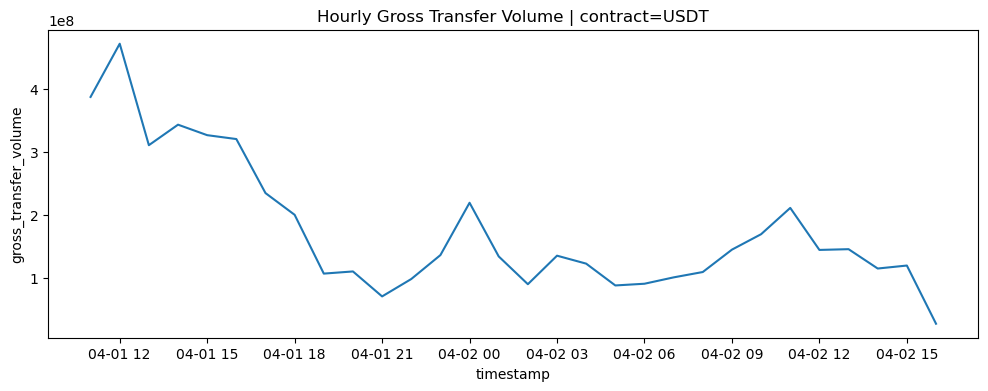

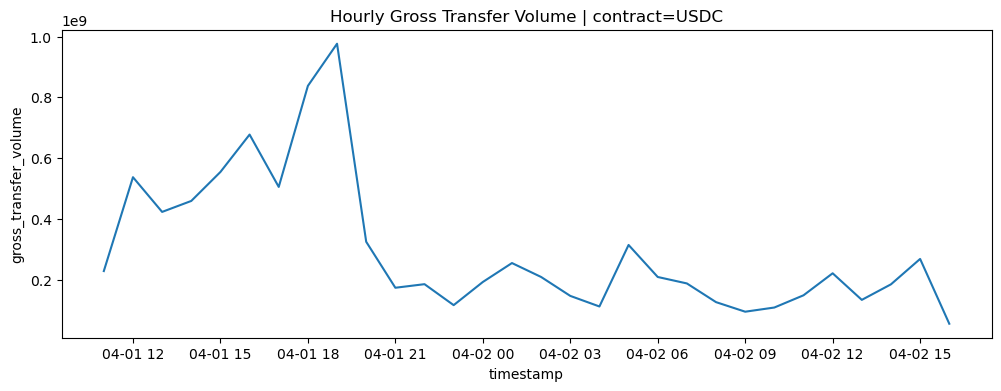

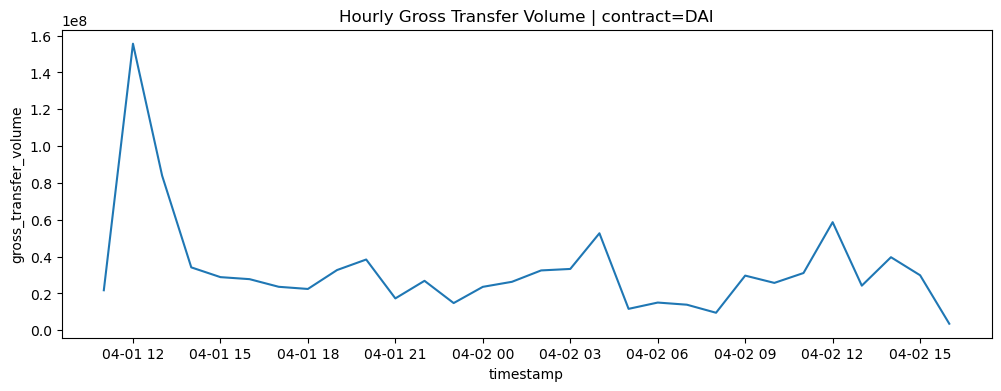

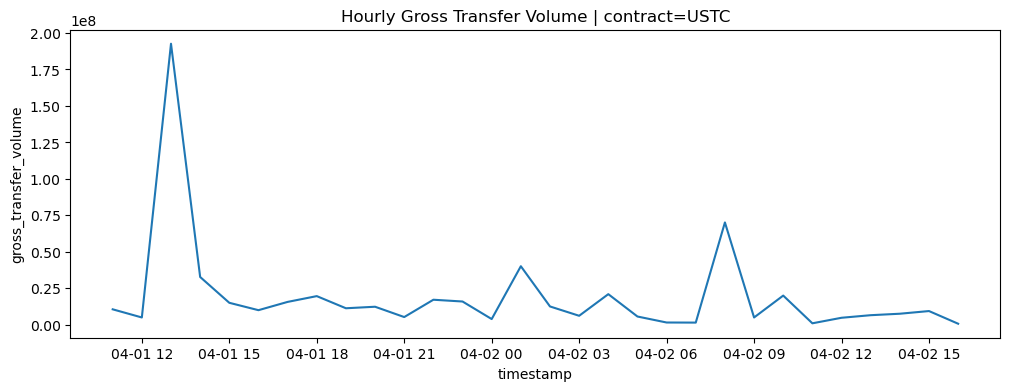

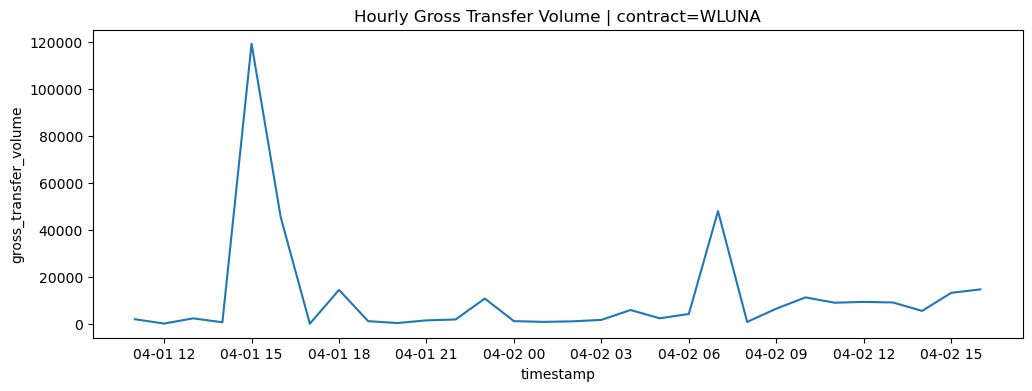

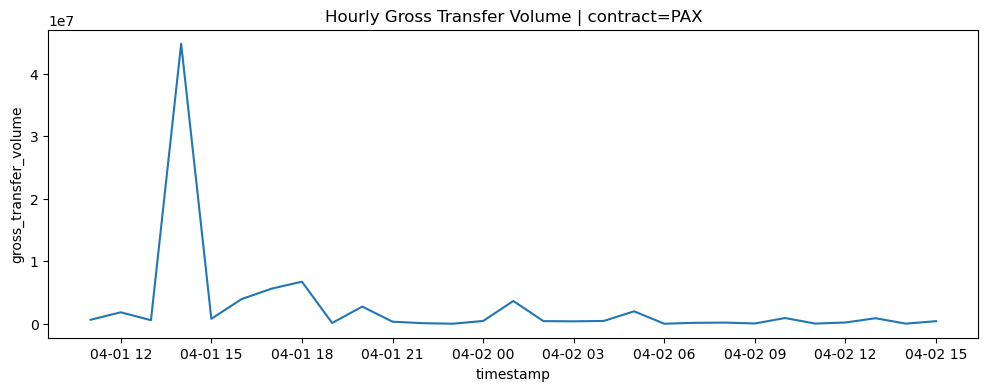

In [47]:
import matplotlib.pyplot as plt

for c in top_contract_list:
    sub = hourly_top[hourly_top["token"] == c]
    plt.figure(figsize=(12,4))
    plt.plot(sub["timestamp"], sub["gross_transfer_volume"])
    plt.title(f"Hourly Gross Transfer Volume | contract={c}")
    plt.xlabel("timestamp")
    plt.ylabel("gross_transfer_volume")
    plt.show()


In [48]:
from pathlib import Path
out_dir = Path("../data/processed/terra")
out_dir.mkdir(parents=True, exist_ok=True)

hourly_by_contract.to_csv(out_dir / "terra_hourly_transfer_volume_by_contract.csv", index=False)
print("Saved:", out_dir / "terra_hourly_transfer_volume_by_contract.csv")

Saved: ..\data\processed\terra\terra_hourly_transfer_volume_by_contract.csv
